# K-Min-Sum-Radii LP proof of concept

The goal is to find the optimal solution to a linear program that calculates a k-msr solution to a given selection of points and an integer k. Gurobi is used to calculate the solution within the necessary constraints. This notebook is supposed to be an exercise to find these specific constraints and to improve my grasp on the problem itself, before proceeding with implementing an algorithm of my own.

In [1]:
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import DistanceMetric
from scipy.spatial import distance as dist

We need data points to perform the clustering on. An easy stand-in for actual data are sklearn blobs, that form very obvious clusters and are verifiable by hand if they are small enough.

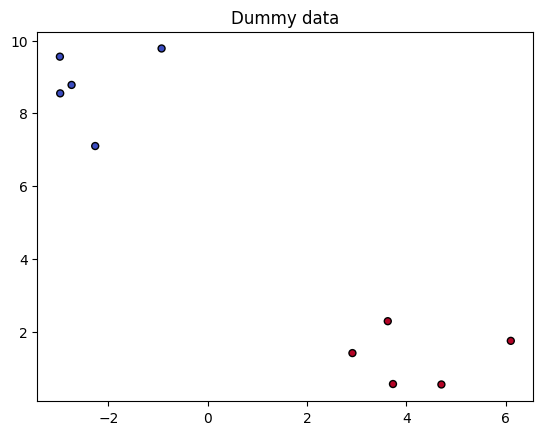

In [2]:
# generate dummy data for k=2
k = 2
points, cluster_membership = make_blobs(
    n_samples=10,
    n_features=2,
    centers=k,
    random_state=42
)

plt.title("Dummy data")
plt.scatter(points[:, 0], points[:, 1], marker='o', c=cluster_membership, s=25, edgecolor="k", cmap="coolwarm")
plt.show()

In [3]:
points

array([[ 2.914961  ,  1.41088215],
       [-2.97261532,  8.54855637],
       [-0.92998481,  9.78172086],
       [ 3.62704772,  2.28741702],
       [-2.743351  ,  8.78014917],
       [ 3.73185476,  0.56086598],
       [ 4.70740704,  0.5484215 ],
       [-2.26723535,  7.10100588],
       [-2.97867201,  9.55684617],
       [ 6.10552761,  1.74739338]])

In [4]:
# distance function
distances = DistanceMetric.get_metric('euclidean')

# we need all distances as possible radii
radii = distances.pairwise(points)
radii


array([[ 0.        ,  9.25256441,  9.21165289,  1.12932761,  9.29099516,
         1.17891599,  1.98914584,  7.69627618, 10.05443384,  3.20826356],
       [ 9.25256441,  0.        ,  2.38600797,  9.09711043,  0.32587935,
        10.42847625, 11.08985579,  1.61026809,  1.00830799, 11.34321369],
       [ 9.21165289,  2.38600797,  0.        ,  8.77103959,  2.07157978,
        10.33232369, 10.81822554,  2.99574228,  2.06099196, 10.67936575],
       [ 1.12932761,  9.09711043,  8.77103959,  0.        ,  9.09601839,
         1.72972917,  2.047262  ,  7.61007297,  9.82243011,  2.53662928],
       [ 9.29099516,  0.32587935,  2.07157978,  9.09601839,  0.        ,
        10.46350351, 11.10293366,  1.74533902,  0.81156282, 11.30319895],
       [ 1.17891599, 10.42847625, 10.33232369,  1.72972917, 10.46350351,
         0.        ,  0.97563165,  8.87482462, 11.22313811,  2.65370873],
       [ 1.98914584, 11.08985579, 10.81822554,  2.047262  , 11.10293366,
         0.97563165,  0.        ,  9.56984841

## Defining the ILP

In [5]:
# model
m = gp.Model("kmsr")

# variables
y = m.addVars(len(points), len(points), vtype=GRB.BINARY, name="Y") # for dummies (me): adds a 10x10 grid of binary variables y_ij that can be either 0 or 1, which will be used to check which clusters overlap a given point

Set parameter Username
Set parameter LicenseID to value 2629995
Academic license - for non-commercial use only - expires 2026-03-01


In [7]:
# objective:
m.setObjective(gp.quicksum([y[i, j] * radii[i][j] for i in range(len(radii)) for j in range(len(radii[i]))]),  GRB.MINIMIZE) # should be the minimization of the sum of active y_ij times their respective radii

In [11]:
# constraints:

# every point is covered by atleast one center/radius y_ij
"""for i in range(len(points)):
    m.addConstr(gp.quicksum([y[i, j] for j in range(len(points)) if dist.euclidean(points[i], points[j]) <= radii[i][j]]) >= 1, "every_point_covered") # every row must have one center active, meaning every point must be covered by one cluster"""
for n in range(len(points)):
        m.addConstr(gp.quicksum([y[i, j] for j in range(len(radii)) for i in range (len(radii)) if radii[i][j] >= dist.euclidean(points[n], points[i])]) >= 1, "every_point_covered")

# exactly k centers open in total (not per row of y, so we don't get the sum of 10 different solutions)
m.addConstr(gp.quicksum([y[i, j] for i in range (len(radii)) for j in range(len(radii[i]))]) == k, "select_k_Centers")

<gurobi.Constr *Awaiting Model Update*>

In [12]:
# do the thing
m.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 5800X3D 8-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 11 rows, 100 columns and 650 nonzeros
Model fingerprint: 0xfe8c19d6
Variable types: 0 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-01, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Found heuristic solution: objective 10.1483095
Presolve added 1 rows and 0 columns
Presolve removed 0 rows and 50 columns
Presolve time: 0.00s
Presolved: 12 rows, 50 columns, 230 nonzeros
Variable types: 0 continuous, 50 integer (49 binary)

Root relaxation: objective 4.118842e+00, 13 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    

In [13]:
m.display()

Minimize
9.252564411486777 Y[0,1] + 9.211652885195841 Y[0,2] + 1.1293276095427889 Y[0,3]
+ 9.290995160230224 Y[0,4] + 1.1789159864189187 Y[0,5] + 1.9891458420897201 Y[0,6]
+ 7.6962761848431205 Y[0,7] + 10.054433840652383 Y[0,8] + 3.2082635560794674 Y[0,9]
+ 9.252564411486777 Y[1,0] + 2.386007970432814 Y[1,2] + 9.09711043102228 Y[1,3]
+ 0.3258793503670385 Y[1,4] + 10.428476245667978 Y[1,5] + 11.089855790282579 Y[1,6]
+ 1.6102680889822019 Y[1,7] + 1.0083079879584977 Y[1,8] + 11.343213694843513 Y[1,9]
+ 9.211652885195841 Y[2,0] + 2.386007970432814 Y[2,1] + 8.771039589361056 Y[2,3]
+ 2.0715797793648414 Y[2,4] + 10.332323687401857 Y[2,5] + 10.818225543846411 Y[2,6]
+ 2.9957422766460393 Y[2,7] + 2.06099196348809 Y[2,8] + 10.67936575209419 Y[2,9]
+ 1.1293276095427889 Y[3,0] + 9.09711043102228 Y[3,1] + 8.771039589361056 Y[3,2]
+ 9.096018392899788 Y[3,4] + 1.7297291664908652 Y[3,5] + 2.0472619973026385 Y[3,6]
+ 7.610072973300392 Y[3,7] + 9.822430113106464 Y[3,8] + 2.536629276369174 Y[3,9]
+ 9.2

C:\Users\Mattis\AppData\Local\Temp\ipykernel_10232\137993151.py:1: DeprecationWarning: Model.display() is deprecated
  m.display()


In [15]:
final_centers = [points[i] for i in range(len(points)) for j in range(len(radii[i])) if y[i, j].x == 1]
final_radii = [radii[i][j] for i in range(len(radii)) for j in range(len(radii[i])) if y[i, j].x == 1]

print("Optimal centers:")
for i in range(len(final_centers)): 
    print(f"Center {i} at point {final_centers[i]} with radius {final_radii[i]}")

Optimal centers:
Center 0 at point [-2.743351    8.78014917] with radius 2.0715797793648414
Center 1 at point [4.70740704 0.5484215 ] with radius 2.0472619973026385


# Visual Solution

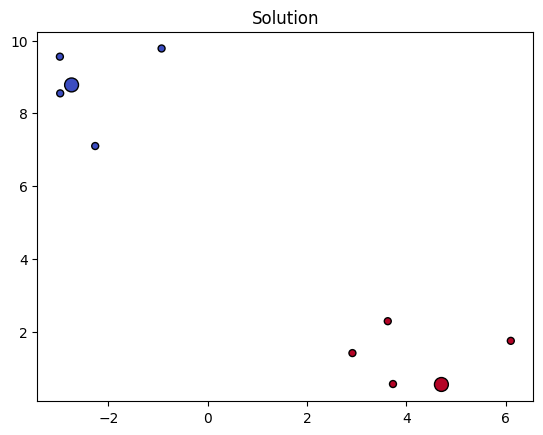

In [16]:
# centers are enlarged
plt.title("Solution")
sizes = [100 if tuple(point) in map(tuple, final_centers) else 25 for point in points]
plt.scatter(points[:, 0], points[:, 1], marker='o', c=cluster_membership, s=sizes, edgecolor="k", cmap="coolwarm")
plt.show()